Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


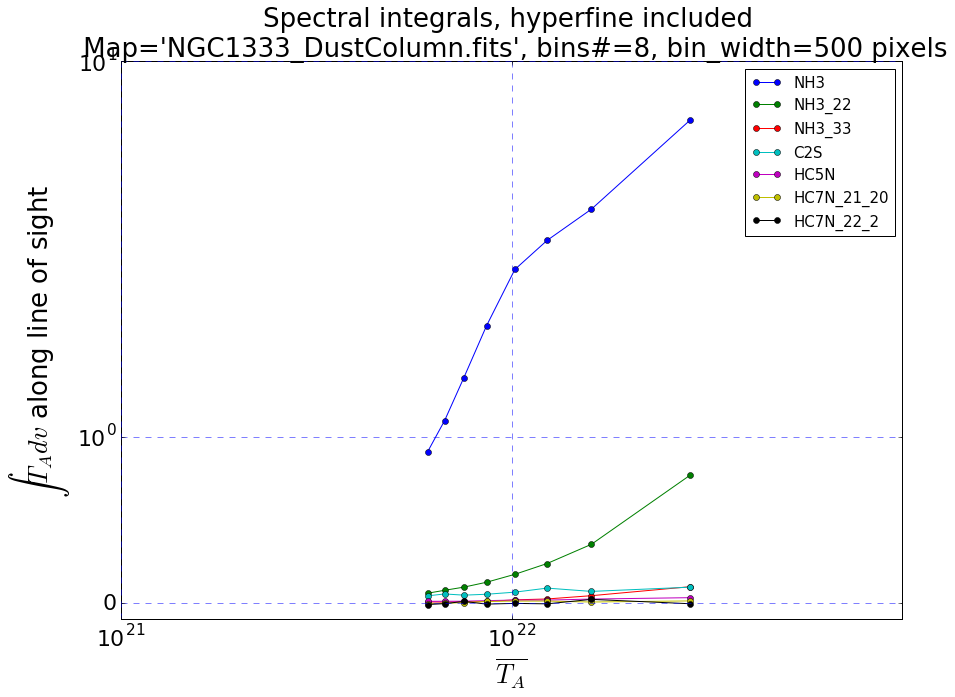

In [20]:
# What are the variables we want set as default?
# Taking out the user input leaves much less comparison options? what do we want to compare actually?
# Now bin_width=500, wanted_bin=0 occure as kew words in main() and in binning() function. Is this OK?
# Do we want to have global variable declarations in the header?

import pyspeckit as psk
from spectral_cube import SpectralCube
import astropy.units as u

import GAS
from spectral_cube import SpectralCube
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import astropy.units as u
from astropy.io import fits
from astropy.table import Table

import pyspeckit as psk
from pyspeckit.spectrum.models import ammonia
from pyspeckit.spectrum.models import ammonia_constants, ammonia, ammonia_hf
from pyspeckit.spectrum.models.ammonia_constants import freq_dict
from pyspeckit.spectrum.units import SpectroscopicAxis, SpectroscopicAxes

%pylab
%matplotlib inline

vlsr = fits.getdata('NGC1333_Vlsr_v1.fits')
files =['NGC1333_NH3_11_DR1.fits', 'NGC1333_NH3_22_DR1.fits', 'NGC1333_NH3_33_DR1.fits', 
       'NGC1333_C2S_DR1.fits',
       'NGC1333_HC5N_DR1.fits',
        'NGC1333_HC7N_21_20_DR1.fits', 'NGC1333_HC7N_22_21_DR1.fits']


# lines_margins = {files[0]: [[-1.5, 3.],[6.25, 11.],[18.5,22.5], [-8.5,-4.5], [-21., -16.5]], files[1]: [[-2., 3.], [-17., -13.5], [15.5, 19.]],
#                  files[2]: [[-4.25, 4]], files[3]: [[-1.5, 3.]], files[4]: [[-2, 4.]], files[5]: [[-1.5, 3.]],
#                     files[6]: [[-1.5, 3.]]}
# noise_margins = {files[0]: [12., 17.], files[1]: [5., 12.5], files[2]: [-12, -10], files[3]: [-12, -10], files[4]: [10., 27.5], files[5]: [5., 15.],
#                     files[6]: [5., 15.]}

bin_width = 500
this_bin = 8
map_temp = 'NGC1333_Temperature.fits'
map_column_dens = 'NGC1333_DustColumn.fits'
# map_binning = 'OrionA_NH3_11_base_DR1_mom0.fits'

def main(this_bin, bin_width):   
    # This is the main routine.
    y, x, med = binning(bin_width, this_bin, map_mame = map_column_dens)
    t, table_names = make_table_and_plot(files, this_bin, bin_width, y, x, table_content = 'spectral_integral')
    t
    
#     plot_spectra(this_bin, bin_width)
#     spec_curve_fit(1)
#     t, table_names = make_table(files, this_bin, bin_width, y, x)
#     plot_table(files, this_bin, bin_width, y, x)
    


def plot_spectra(this_bin, bin_width, map_name = map_column_dens, **kwargs):
    # line belows causes a loop of plots, their number=this_bin. If you want just a single plot, comment the line out
    for this_bin in range(this_bin):
        loop_count = 0
        fig = plt.figure(figsize=(14,10))
        # for plotting plots in a single figure put plt.figure before all the .plot commands
        # otherwise you will get the plots in a different figures

        y, x, med = binning(bin_width, this_bin)
        # line below rounds med to 3 significant figures, means: 1.23456E+22 -> 1.23E+22
        med_rounded = float('%.3g' % med)

        for file_name in files:                        
            sp_av, cube = averaging(file_name, y, x)
            thiscube_spectrum_dv, cube, offset_velocity, sp_av = averaging_over_dopplervel(file_name, y, x)
            #Change to velocity axis and such here as well.  Then average all spectra with that bin label.
            ax = fig.add_subplot(len(files),1,loop_count+1)
            plt.plot(offset_velocity,thiscube_spectrum_dv, drawstyle='steps')
            plt.yticks(np.arange(min(thiscube_spectrum_dv), max(thiscube_spectrum_dv), (max(thiscube_spectrum_dv)-min(thiscube_spectrum_dv))/3)) 
            plt.xticks(np.arange(-30, 30, 5))
            ax.tick_params(axis='x', labelsize=22)
            ax.tick_params(axis='y', labelsize=20)

            # the two line below make the x-axis to be labelled with number values only for the very bottom spectrum.
            # It is a way to save space and not get overwhelmed with number on the plot.
            if file_name != files[-1]:
                plt.setp(ax.get_xticklabels(), visible=False)

            file_name = file_name.strip('L1455_').strip('_all.fits').strip('NGC1333').strip('_DR1_all.fits').strip('OrionA_').strip('_base_DR1.fits')
            plt.legend([file_name], bbox_to_anchor=(1.01, 1.15), prop={'size':20})

            loop_count += 1        

        fig.suptitle("map=%r: Averaged spectrum from \n $\overline{T}_{antena} = %rK$, (bin_width = %r pixels, bin # = %r)"
                     %(map_name, med_rounded, bin_width, this_bin), fontsize=20)
        plt.ylabel(r'$T_{antena} (K)$', fontsize = 24)
        plt.xlabel(r'$V_{\mathrm{LSR}}\ (km \cdot s^{-1})$', fontsize = 24)
        # I use .pdf for savefig through out the code, because it gives more than suficient resolution
        plt.savefig("map=%r:BinsAveraging_bin_width=%rthis_bin=%r.pdf" %(map_name, bin_width, this_bin))
        plt.show()

      
def binning(bin_width, this_bin, map_name = map_column_dens, **kwargs):
    """A function creating brightness bins of pixels, and eventualy a map, in the given spectral cube"""
#     cube = SpectralCube.read(map_name)
#     cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
#     Tmax = cube.apply_numpy_function(np.nanmax,axis=0) # array of the maximum values in the spectra of each pixel
#     baddata = nd.morphology.binary_dilation(np.isnan(Tmax),np.ones((25,25)))
#     Tmax[baddata]=0.0
#     Tmax[np.isfinite(Tmax)]
    
    Tmax = fits.getdata(map_name)
    bin_arr = np.sort(Tmax[np.isfinite(Tmax)])
    bin_arr2 = bin_arr[:: - bin_width] # this creates an array of the bin margins, in which every bin has a width of "bin_width"  
    bins = np.digitize(Tmax,bin_arr2)
    bins = [x-1 for x in bins] # this and the following line correct the fact that there is otherwise
    bins = np.array(bins) # only one pixel in the bin = 0
    y, x = np.where(bins==this_bin)
    med = round(np.median(Tmax[y,x]), 2)
    return y, x, med

def averaging(file_name, y, x):
    cube = SpectralCube.read(file_name)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    sp_av = np.nanmean(cube.filled_data[:,y,x].value,axis=1)
    return sp_av, cube

def averaging_over_dopplervel(file_name, y, x):
    cube = SpectralCube.read(file_name)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    sp_av = np.nanmean(cube.filled_data[:,y,x].value,axis=1)
    thiscube_spectrum_dv, offset_velocity = GAS.gasBinning.BinByMask(cube, CentroidMap = vlsr, x = x, y = y)
    return thiscube_spectrum_dv, cube, offset_velocity, sp_av


def make_table_and_plot(files, this_bin, bin_width, y, x, map_name = map_column_dens, table_content = 'spectral_integral', **kwargs):        
    if table_content == 'spectral_integral':
        table_names = ['map', 'bin width', 'bin#', 'quantity_med']
        for f in files:
            table_names.append(f.strip('NGC1333').strip('_DR1_all.fits'))
            table_names.append(f.strip('NGC1333').strip('_DR1_all.fits')+'_err')
        y_label=r'$\int T_A dv$ along line of sight'
            
        arr = np.arange(len(table_names)*this_bin).reshape(this_bin, len(table_names))
        t = Table(arr, names=table_names, meta={'name': 'table'}, dtype=['S30'] + (len(table_names)-1)*['f8']) 

        for bin_num in range(this_bin):
            y, x, med = binning(bin_width, bin_num)
            row = [map_name, bin_width, bin_num, med]
            for file_name in files:
                thiscube_spectrum_dv, cube, offset_velocity, sp_av = averaging_over_dopplervel(file_name, y, x)
                sp_integral, error_bar = spectral_integral_and_err(offset_velocity, thiscube_spectrum_dv, cube, file_name)
                row.append(sp_integral)
                row.append(error_bar)
            t[bin_num] = row
        
        fig = plt.figure(figsize=(14,10))
        ax1 = fig.add_subplot(111)
        ax1.set_title("Spectral integrals, hyperfine included \n Map=%r, bins#=%r, bin_width=%r pixels"%(map_name, this_bin, bin_width), fontsize=26)    
        plt.xlabel(r'$\overline{T_A}$', fontsize = 26)
        plt.ylabel(r'$\int T_A dv$ along line of sight', fontsize = 26)
        ax1.set_xscale('symlog', linthreshx=1)
        ax1.set_yscale('symlog')
        ax1.grid(b=True, which='major', color='b', linestyle='--')
        ax1.tick_params(axis='x', labelsize=22)
        ax1.tick_params(axis='y', labelsize=22)
        
        for file_name in files:
            column_name = file_name.strip('NGC1333').strip('_DR1_all.fits') 
            ax1.errorbar(t['quantity_med'], t[column_name], marker='o', linestyle='-', label=str(column_name)) #yerr=t[column_name+'_err'],
        
        leg = ax1.legend(prop={'size':15})
        plt.savefig("Map=%r_%r_of_$NH_3$_bins#=%r_bin_width%r.pdf" %(map_name, table_content, bin_width, this_bin))
        plt.show()
        plt.close(fig)        
    
            
    else:
        if table_content == 'chemical_abundance':
            table_names = ['map', 'bin width', 'bin#', 'log(N(H2))', 'chem. abund.', 'chem_ab_err']
            y_label=r'chem. abund. $log\left(\frac{N(NH_3)}{N(H_2)}\right)$'
            arr = np.arange(len(table_names)*this_bin).reshape(this_bin, len(table_names))
            t = Table(arr, names=table_names, meta={'name': 'table'}, dtype=['S30'] + (len(table_names)-1)*['f8'])
            for bin_num in range(this_bin):
                y, x, med = binning(bin_width, bin_num)
                # in the bottom two lines the medium values of the collumn density of this region is being obtained
                # in is equal to log(N(H_2))
#                 column_dens_value = fits.getdata(map_column_dens)  
#                 logNH2 = log10(round(np.median(column_dens_value[y,x]), 2))
                logNH2 = log10(float('%.3g' % med))
                parameter_info, error_bars = spec_curve_fit(bin_num)
                logNNH3 = parameter_info[2].value
                chem_abund = logNNH3 - logNH2 # = log(N(NH3)/N(H2))
                logNNH3_error_bar = error_bars[2] #needs to be corrected, see standart deviation of logarithmic calculations
                row = [map_name, bin_width, bin_num, logNH2, chem_abund, logNNH3_error_bar]
                t[bin_num] = row
                
            
        elif table_content == 'temperature_kin':
            table_names = ['map', 'bin width', 'bin#', 'log(N(H2))', 'Temp_kin', 'Temp_kin_err']
            y_label = r'$T_{kin}$'
            arr = np.arange(len(table_names)*this_bin).reshape(this_bin, len(table_names))
            t = Table(arr, names=table_names, meta={'name': 'table'}, dtype=['S30'] + (len(table_names)-1)*['f8'])
            for bin_num in range(this_bin):
                y, x, med = binning(bin_width, bin_num)
                # in the bottom two lines the medium values of the collumn density of this region is being obtained
                # in is equal to log(N(H_2))
#                 column_dens_value = fits.getdata(map_column_dens)  
#                 logNH2 = log10(round(np.median(column_dens_value[y,x]), 2))
                logNH2 = log10(float('%.3g' % med))
                parameter_info, error_bars = spec_curve_fit(bin_num)
                Temp_kin = parameter_info[0].value
                Temp_kin_error_bar = error_bars[0]
                row = [map_name, bin_width, bin_num, logNH2, Temp_kin, Temp_kin_error_bar]
                t[bin_num] = row
                
        
        elif table_content == 'line_width':
            table_names = ['map', 'bin width', 'bin#', 'log(N(H2))', 'line_width', 'line_width_err']
            y_label = r'line width $\sigma$'
            arr = np.arange(len(table_names)*this_bin).reshape(this_bin, len(table_names))
            t = Table(arr, names=table_names, meta={'name': 'table'}, dtype=['S30'] + (len(table_names)-1)*['f8'])
            for bin_num in range(this_bin):
                y, x, med = binning(bin_width, bin_num)
                # in the bottom two lines the medium values of the collumn density of this region is being obtained
                # in is equal to log(N(H_2))
                column_dens_value = fits.getdata(map_column_dens)  
                logNH2 = log10(round(np.median(column_dens_value[y,x]), 2))
                parameter_info, error_bars = spec_curve_fit(bin_num)
                line_width = parameter_info[3].value
                line_width_error_bar = error_bars[3] #needs to be corrected, see standart deviation of logarithmic calculations
                row = [map_name, bin_width, bin_num, logNH2, line_width, line_width_error_bar]
                t[bin_num] = row
                
#     t.write('filename.txt', format='latex') # - COOL!!!
#     t.write('NGC1333_bin_width=%r_MaxBin#=%r_no_header.txt' %(bin_width, this_bin), format='ascii.no_header')
#     t.write('OrionA:Table_spec_integrals_corrected_bin_width=%r_MaxBin#=%r_HYPERFINE.txt' %(bin_width, this_bin), format='ascii.fixed_width')
    
    if table_content != 'spectral_integral':
        fig = plt.figure(figsize=(14,10))
        ax1 = fig.add_subplot(111)
        ax1.set_title("Map=%r: \n %r of $NH_3$. bins#=%r, bin_width=%r pixels"%(map_name, table_content, this_bin, bin_width), fontsize=24) #     
        plt.xlabel(r'$log\left(N(H_2)\right)$ along line of sight', fontsize = 28) # don't forget the r infront of '...' for latex formula
        plt.ylabel(y_label, fontsize = 28)
        ax1.tick_params(axis='x', labelsize=20)
        ax1.tick_params(axis='y', labelsize=20)
        # the line below sets the y-range to be 5% above the max-value and 5% below the min-value
        ax1.set_ylim([np.amin(t[table_names[-2]]) - 0.05*np.absolute(amin(t[table_names[-2]])), np.amax(t[table_names[-2]]) + 0.05*np.absolute(amax(t[table_names[-2]]))])

        transpa_factors = [[1,0,0,0.15] for i in range(len(t))]
        plt.plot(t[table_names[-3]], t[table_names[-2]], linewidth=3.0)
        for x, y, err, transpa_factor in zip(t[table_names[-3]], t[table_names[-2]], t[table_names[-1]], transpa_factors):
            ax1.errorbar(x, y, err, marker='o', color=transpa_factor, linestyle='-', label=table_names[-2], lw=2) #lw is the line width of bar # yerr=t[column_name+'_err'],

    #             leg = ax1.legend(prop={'size':10})
        plt.savefig("Map=%r_%r_of_$NH_3$_bins#=%r_bin_width%r.pdf" %(map_name, table_content, bin_width, this_bin))
        plt.show()
        plt.close(fig)
    
    return t, table_names
    
    
def spectral_integral_and_err(offset_velocity, thiscube_spectrum_dv, cube, file_name):
    # first, calculating the integral
    lines_margins = {'NH3_11': [[-1.5, 1.5],[6.75, 8.5],[18.75,20.], [-8.5,-7.], [-20.5, -19.25]], 'NH3_22': [[-1.5, 1.5], [-17.5, -15.5], [15., 17.]],
                 'NH3_33': [[-1.5, 1.5]], 'C2S': [[-1.5, 1.5]], 'HC5N': [[-1.5, 1.5]], 'HC7N_21_20': [[-1.5, 1.5]],
                    'HC7N_22_21': [[-1.5, 3.]]}
    noise_margins = {'NH3_11': [12., 17.], 'NH3_22': [5., 12.5], 'NH3_33': [-12, -10], 'C2S': [-12, -10], 'HC5N': [10., 27.5], 'HC7N_21_20': [5., 15.],
                    'HC7N_22_21': [5., 15.]}
    
    if 'NH3_11' in file_name:
        file_name = 'NH3_11'
    elif 'NH3_22' in file_name:
        file_name = 'NH3_22'
    elif 'NH3_33' in file_name:
        file_name = 'NH3_33'
    elif 'C2S' in file_name:
        file_name = 'C2S'
    elif 'HC5N' in file_name:
        file_name = 'HC5N'
    elif 'HC7N_21_20' in file_name:
        file_name = 'HC7N_21_20'
    elif 'HC7N_22_21' in file_name:
        file_name = 'HC7N_22_21'
        
        
    # in line below calculating the spectral-bin-width, assuming that all spectral-bins have the same width
    spec_bin_w = (cube.spectral_axis[1] - cube.spectral_axis[2])
    sp_integral = 0

    for line_interval in lines_margins[file_name]:
        ind_line = (line_interval[0] < offset_velocity) & (offset_velocity < line_interval[1])
        sp_integral += np.nansum(thiscube_spectrum_dv[ind_line]) * spec_bin_w

# below calculating the error, based on the standard deviation of the signal noise
        ind_offset = (noise_margins[file_name][0] < offset_velocity) & (offset_velocity < noise_margins[file_name][1])
        std_noise = np.nanstd(thiscube_spectrum_dv[ind_offset])
        # Nchan should be the # of channels, that contribute to the integral (= # of data points in spectral line)
        Nchan = len(thiscube_spectrum_dv[ind_line])
        error = std_noise*np.sqrt(Nchan)
     
    return sp_integral.value, error
    
def spec_curve_fit(bin_num, map_name = map_column_dens):
    # following loop has not good style. One should build in some break statements or error messages
    # if files repeatedly appear in loop.
    for one_file in files:
        if 'NH3_11' in one_file:
            file_name_NH3_11 = one_file
        if 'NH3_22' in one_file:
            file_name_NH3_22 = one_file
        if 'NH3_33' in one_file:
            file_name_NH3_33 = one_file
        
    y, x, med = binning(bin_width, bin_num)

    s11, _, offset_velocity11, sp_av11 = averaging_over_dopplervel(file_name_NH3_11, y, x)
    s22, _, offset_velocity22, sp_av22 = averaging_over_dopplervel(file_name_NH3_22, y, x)
    s33, _, offset_velocity33, sp_av33 = averaging_over_dopplervel(file_name_NH3_33, y, x)
    
    xarr11 = SpectroscopicAxis(offset_velocity11*u.km/u.s, velocity_convention='radio',
                           refX=freq_dict['oneone']).as_unit(u.GHz)
    xarr22 = SpectroscopicAxis(offset_velocity22*u.km/u.s, velocity_convention='radio',
                           refX=freq_dict['twotwo']).as_unit(u.GHz)
    xarr33 = SpectroscopicAxis(offset_velocity33*u.km/u.s, velocity_convention='radio',
                           refX=freq_dict['threethree']).as_unit(u.GHz)
        
    sp11 = psk.Spectrum(data=s11, xarr=xarr11, xarrkwargs={'unit':'km/s'},unit='K')
    sp22 = psk.Spectrum(data=s22, xarr=xarr22, xarrkwargs={'unit':'km/s'},unit='K')
    sp33 = psk.Spectrum(data=s33, xarr=xarr33, xarrkwargs={'unit':'km/s'},unit='K')
    
    # This joins all the spectra together into one object.
    allspec = psk.Spectra([sp11,sp22,sp33])
    allspec.xarr.as_unit('Hz',velocity_convention='radio')
    # This add the cold_ammonia model to the list of things we can use for fitting
    allspec.specfit.Registry.add_fitter('cold_ammonia',ammonia.cold_ammonia_model(),6)
    # This does the fit.  The values of the guess are 
    # Kinetic Temperature (usually about 15 to 25 K)
    # Excitation Temperature (between 2.73 K and the excitation temperature)
    # Log Column Density of ammonia
    # Line width (~1 km/s)
    # Offset velocity (you will usually use 0 instead of 8.5)
    # Ortho fraction (leave at 0)
    allspec.specfit(fittype='cold_ammonia',guesses=[23,5,13.1,1,0,0])
    
    # You can make a plot here.
    fig = plt.figure()
    allspec.plotter()
    allspec.specfit.plot_fit(lw=1, components=True)
    plt.xlim((23.692,23.697))
#     plt.xlim((23.72,23.725))
#     plt.xlim((23.8692, 23.8708))
#     plt.savefig("OrionA:pyspeckit_fit_bin_width=%rthis_bin=%r.ps" %(bin_width, this_bin))
#     plt.savefig("Map=%r:bin_num=%r_pyspeckit_fit_NH3_11TEST.eps"%(map_name, bin_num))
#     plt.show()
    plt.close(fig)
    
    # returns the values of the fitted parameters: T_K, T_ex, N, sigma, v, F_0
    return allspec.specfit.parinfo, allspec.specfit.parinfo.errors
    
main(this_bin, bin_width)


In [113]:
transpa_factors = [[1,0,0,0.2] for i in range(3)]
for x, factor in zip([10,20,30], transpa_factors):
    print x, factor

10 [1, 0, 0, 0.2]
20 [1, 0, 0, 0.2]
30 [1, 0, 0, 0.2]


In [12]:
a = float('%.1g' % 0.062)
print a
print [[1,2,3] for i in range(5)]
print [1,2,3,4,5,6][0:-3]

0.06
[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]]
[1, 2, 3]
